# Thinking Non-Linearly about the Effective AoA of a FWTD

Within all the current linear analysis of FWTD's the following equation has been used to describe the change in AoA of the FWT with respect to the flare and fold angle:

$\Delta\alpha_h(\Lambda,\theta) = -\arctan(\tan{\theta} \sin{\Lambda}$)

where $\theta$ is the fold angle and $\Lambda$ is the flare angle

This is derived using small angle approximations. By considering this equation at some critical locations we can highlight some of the shortcomings of the equation

### Fold Angle of 90 Degrees

$\Delta\alpha_h(\Lambda)\rvert_{\theta = \frac{\pi}{2}} = \infty$

This is obviously incorrect, and from inspection of the geomtry it is clear that if $\Lambda = 0 \to \Delta\alpha = 0 $ and $\Lambda \lt 0 \to \Delta\alpha < 0$

### Flare Angle of 0 Degrees

$\Delta\alpha_h(\theta)\rvert_{\Lambda = 0} = 0$

Or more over the AoA of the FWT is not a function of theta if there is no flare angle.

This again can be disproven by considering a wing at the initial conditions:

$\alpha = \alpha_r, \Lambda = \theta = 0$

In this condition the AoA of the FWT must be the AoA of the main wing, $\alpha_r$. However, when you then rotate theta up to $\pm\frac{\pi}{2}$ the AoA of the FWT tends to ZERO! 

$\theta = \pm\frac{\pi}{2}, \Lambda = 0, \alpha_h = 0 $

i.e. $\Delta\alpha_h$ is a function of $\alpha_r$ & $\theta$ even if $\Lambda = 0$

# So What is the Equation for $\Delta\alpha_h$ ?

What is clear is that $\Delta\alpha_h = f(\alpha_r,\Lambda,\theta)$

To find what this function is we will use rotation matrices to go from the 'Velocity Frame of Reference' to the 'Hinge Frame of Reference'. For completeness we will also consider the effect of yawslip, e.g. $\gamma$. Hence $\Delta\alpha_h = f(\alpha_r,\Lambda,\theta, \gamma)$

In the Velocity frame of reference the velocity vector is:

$\mathbf{V} = \begin{bmatrix}u\\0\\0\end{bmatrix}$ 

where $u$ is the velocity magnitude. The aim is to translate this vector into the 'hinge reference frame' in which
1. $y$ runs along the leading edge of the FWT
2. $x$ runs along the chord line of the FWT

### Preamble

In [2]:
import sympy as sym
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

imageFolder = r'C:\Users\qe19391\OneDrive - University of Bristol\Desktop' '\\'

In [3]:
## a/c to wind transform
alpha,beta = sym.symbols(['alpha','beta'])
Ac_V = sym.rot_axis3(beta)*sym.rot_axis2(alpha)   # transform from a/c to the velocity frame 


## a/c to Hinge transform
Lambda,theta = sym.symbols(['Lambda','theta'])


H_Ac = sym.trigsimp(sym.rot_axis3(-Lambda)*\
                    sym.rot_axis1(theta)*  \
                    sym.rot_axis3(Lambda))        # transform from a/c to the hinge frame 


H_V = sym.trigsimp(H_Ac*Ac_V)                      # transform from velocity to hinge reference frame

# Velocity vector in velocity frame is of the form [v 0 0]
u = sym.Symbol('u')
Vv = sym.Matrix([u,0,0])

# Transform into the hinge reference frame
Vh = H_V * Vv

f = sym.lambdify((alpha,beta,Lambda,theta,u),Vh)
Vh

Matrix([
[           u*(-sin(Lambda)*sin(alpha)*sin(theta) + sin(Lambda)*sin(Lambda + beta)*cos(alpha)*cos(theta) - sin(Lambda)*sin(Lambda + beta)*cos(alpha) + cos(alpha)*cos(beta))],
[u*(-sin(Lambda)*cos(alpha)*cos(theta)*cos(Lambda + beta) + sin(Lambda)*cos(alpha)*cos(Lambda + beta) + sin(alpha)*sin(theta)*cos(Lambda) - sin(beta)*cos(alpha)*cos(theta))],
[                                                                                                       u*(sin(alpha)*cos(theta) + sin(theta)*sin(Lambda + beta)*cos(alpha))]])

 The above is the velocity vector in the hinge reference frame. It is quite complex compared to the relative simplicity of the one above, so lets explore it a little bit That is quite complex. Lets explore this vector a little bit....

Note, if we call the above vector $V^h$ and its components $v_N^h,for N=0,1,2$ then the change in $\alpha,\beta$ and $u$ are:

$\Delta\alpha_h = \arctan{\frac{v_2^h}{v_0^h}}-\alpha$

$\Delta\beta_h = \arctan{\frac{v_1^h}{v_0^h}}-\beta$

and importantly the effective velocity changes as well (call $u_h$ the magnitude of the flow perp to the FWT's LE):

$u_h = \sqrt{(v_0^h)^2+(v_2^h)^2}$

This is assuming the cross flow has a negligable effect on the aerodynamics...

Below I am going to calculate this velocity vector for multiple instances of each of the variables, we will then explore the parameter space.

In [4]:
AoAs = np.linspace(-10,10,9)
Thetas = np.linspace(-180,180,361)
Lambdas = np.linspace(-25,25,11)
Betas = np.array([0])

dat = []

for i in AoAs:
    for j in Thetas:
        for k in Lambdas:
            for w in Betas:
                dat.append([i,j,k,w,f(np.deg2rad(i),np.deg2rad(w),np.deg2rad(k),np.deg2rad(j),1).T])
df = pd.DataFrame(data = dat,columns=['Alpha','Theta','Lambda','Beta','V'])
# print(df.head())
df[['v1','v2','v3']] = df['V'].apply(lambda x: pd.Series(x[0]) )
df['Alpha_h'] = np.rad2deg((df['v3']/df['v1']).apply(np.arctan))
df['DeltaAlpha_h'] = df['Alpha_h']-df['Alpha']
df['Beta_h'] = np.rad2deg((df['v2']/df['v1']).apply(np.arctan))
df['DeltaBeta_h'] = df['Beta_h']-df['Beta']
df['u_h'] = np.sqrt(df['v3']*df['v3'] + df['v1']*df['v1'])
# print(df.head())
# #df['Sweep_h'] = (df['v3']/df['v1']).apply(np.arctan)  
df = df.drop(labels='V',axis=1)

## Effect of AoA for $\Lambda = 0$

First lets plot some of the relationships decribed at the top to validate the formula.

When $\Lambda = 0$, for each AoA we should expect to see: 

$\alpha_h\rvert_{\theta = 90^o} = 0$

$\alpha_h\rvert_{\theta = 0^o} = \alpha$

which is exactly what you see below

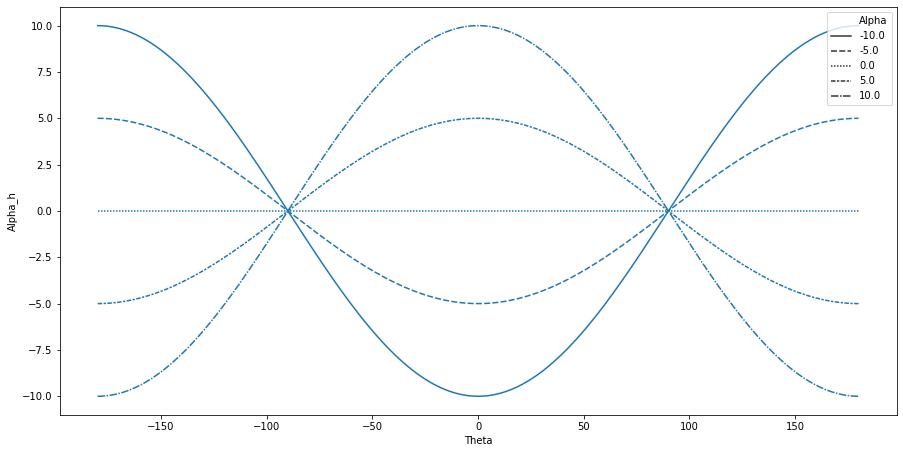

In [5]:
d = df[(pd.Series((np.isin(df['Alpha'],[10,5,0,-5,-10])))) & (df['Lambda']==0) & (df['Beta']==0)]
plt.figure(figsize=(15,7.5))
ax = sns.lineplot(data = d,x='Theta',y='Alpha_h',style = 'Alpha')
plt.savefig(imageFolder +  r'AoA10Lambda0-x_Theta_y_Alphah.png',transparent=True,bbox_inches='tight')

In [6]:
# create a helper function for annotating the maximums
def AnnotateMaxs(data,group,x,y,ax,yOffset=0.5,xOffset=0):
    # annotate the maximum values on delat alpha plot
    maxVals = data[data[y] == data.groupby(group)[y].transform('max')]
    maxVals= maxVals[maxVals[y]!=0]

    for index,row in maxVals.iterrows():
        yv = row[y]
        xv = row[x]
        ax.text(xv+xOffset,yv+yOffset,f'({xv:.0f},{yv:.1f})')

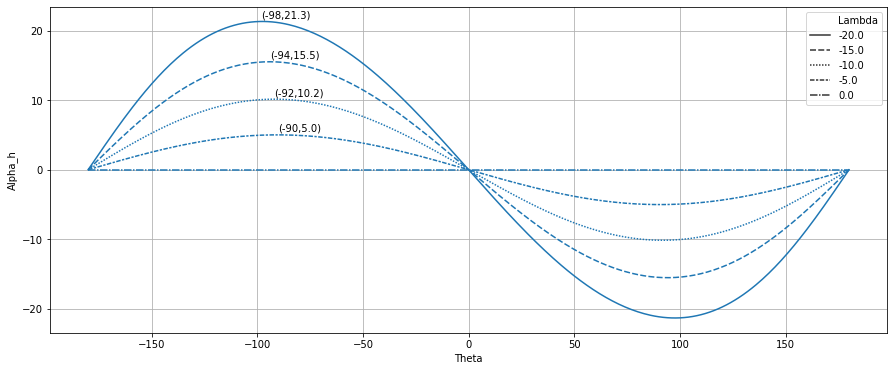

In [7]:
# confirm theta = 90 does not blow up
d = df[(pd.Series((np.isin(df['Lambda'],[-20,-10,0,-5,-15])))) & (df['Alpha']==0) & (df['Beta']==0)]
plt.figure(figsize=(15,6))
ax = sns.lineplot(data = d,x='Theta',y='Alpha_h',style = 'Lambda')
ax.grid()
# annotate maximums
AnnotateMaxs(data=d,group='Lambda',x='Theta',y='Alpha_h',ax=ax)

plt.savefig(imageFolder +  r'AoA0_x_Theta_y_Alphah.png',transparent=True,bbox_inches='tight')

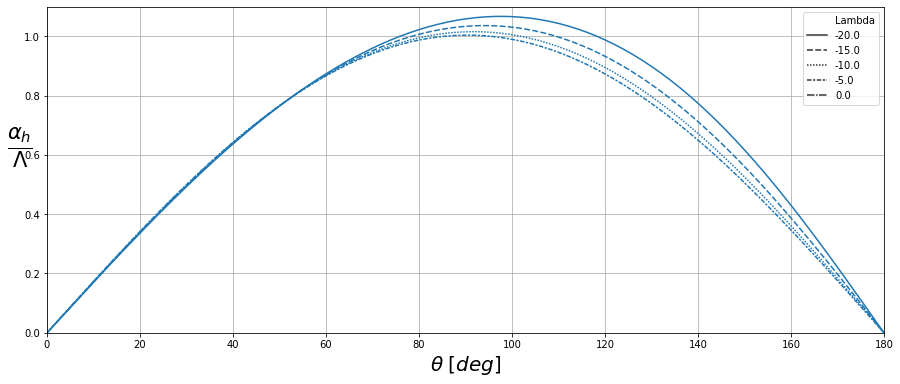

In [8]:
# normalise with respect to the flare angle

# confirm theta = 90 does not blow up
d = df[(pd.Series((np.isin(df['Lambda'],[-20,-10,0,-5,-15])))) & (df['Alpha']==0) & (df['Beta']==0)]
d = d.copy()
d['Norm_Alpha_h'] = d['Alpha_h']/d['Lambda']
plt.figure(figsize=(15,6))
ax = sns.lineplot(data = d,x='Theta',y='Norm_Alpha_h',style = 'Lambda')
ax.grid()
ax.set(xlim=(0,180),ylim=(0,1.1))
ax.set_ylabel(r'$\frac{\alpha_h}{\Lambda}$',rotation = 0,fontsize = 30)
ax.set_xlabel(r'$\theta\;[deg]$',rotation = 0,fontsize = 20)
# annotate maximums
# AnnotateMaxs(data=d,group='Lambda',x='Theta',y='Alpha_h',ax=ax)

plt.savefig(imageFolder +  r'AoA0_x_Theta_y_NormAlphah.png',transparent=True,bbox_inches='tight')

## Sweep Effect

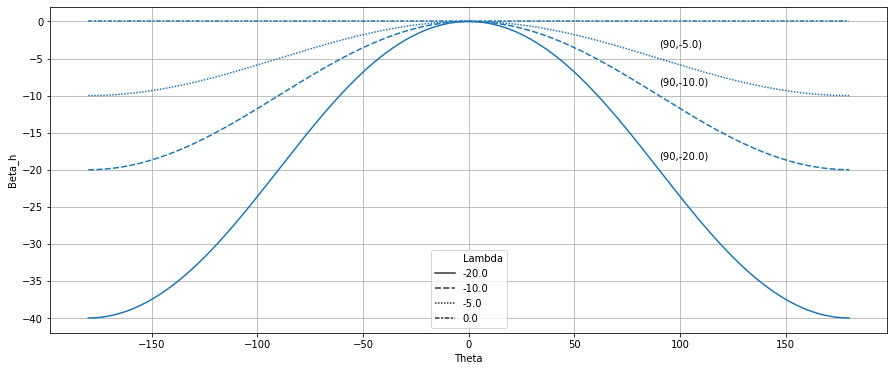

In [9]:
# confirm theta = 90 does not blow up
d = df[(pd.Series((np.isin(df['Lambda'],[0,-5,-10,-20])))) & (pd.Series((np.isin(df['Alpha'],[0])))) & (df['Beta']==0)]
plt.figure(figsize=(15,6))
ax = sns.lineplot(data = d,x='Theta',y='Beta_h',style = 'Lambda')
ax.grid()
# annotate maximums
AnnotateMaxs(data=d[d['Theta']==90],group='Lambda',x='Theta',y='Beta_h',ax=ax,yOffset = 1.5)

plt.savefig(imageFolder +  r'Lambda-20_x_Theta_y_Betah.png',transparent=True,bbox_inches='tight')

### AoA Effect

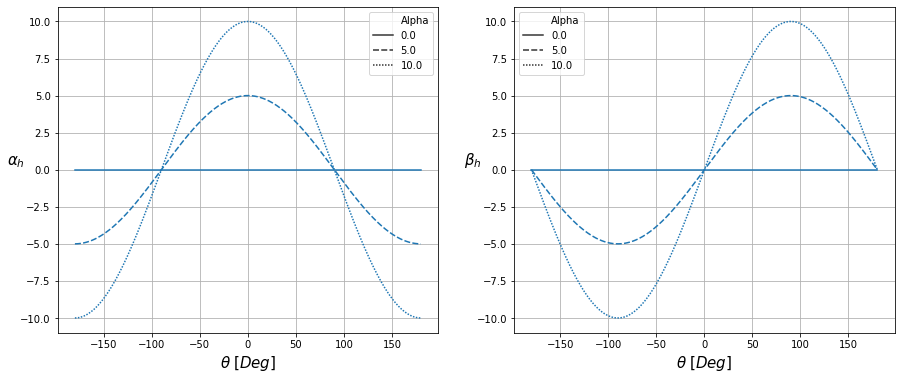

In [10]:
# confirm theta = 90 does not blow up
d = df[(pd.Series((np.isin(df['Lambda'],[0])))) & (pd.Series((np.isin(df['Alpha'],[0,5,10])))) & (df['Beta']==0)]
d = d.copy()
d['u_h^2']= d['u_h']**2
f,axes = plt.subplots(1,2,figsize=(15,6))

ax = sns.lineplot(data = d,x='Theta',y='Alpha_h',style = 'Alpha',ax=axes[0])
ax.set_ylabel(r'$\alpha_h$',fontsize=15,rotation=0)
ax = sns.lineplot(data = d,x='Theta',y='Beta_h',style = 'Alpha',ax=axes[1])
ax.set_ylabel(r'$\beta_h$',fontsize=15,rotation=0)
for i in [0,1]:
    axes[i].grid()
    axes[i].set_xlabel(r'$\theta\;[Deg]$',fontsize=15)

#axes[1].set(xlim=(-180,180),ylim=(0.9,1.02))

plt.savefig(imageFolder +  r'Lambda0_x_Theta_y_Alpha&Beta.png',transparent=True,bbox_inches='tight')

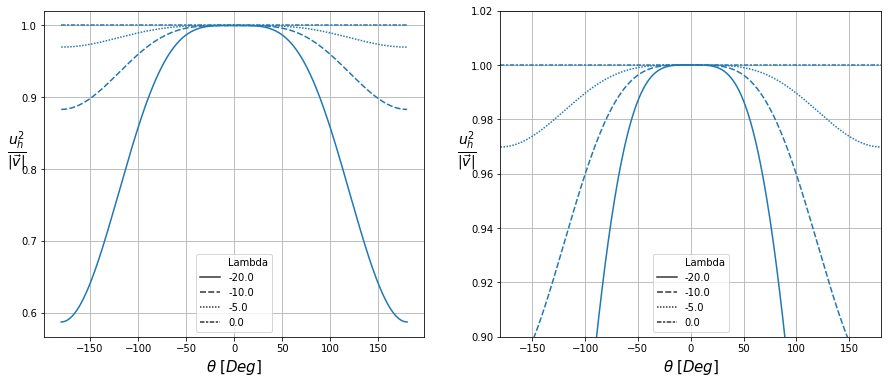

In [11]:
# confirm theta = 90 does not blow up
d = df[(pd.Series((np.isin(df['Lambda'],[0,-5,-10,-20])))) & (pd.Series((np.isin(df['Alpha'],[0])))) & (df['Beta']==0)]
d = d.copy()
d['u_h^2']= d['u_h']**2
f,axes = plt.subplots(1,2,figsize=(15,6))
for i in [0,1]:
    ax = sns.lineplot(data = d,x='Theta',y='u_h^2',style = 'Lambda',ax=axes[i])
    ax.grid()
    ax.set_ylabel(r'$\frac{u_h^2}{|\vec{v}|}$',fontsize=20,rotation=0)
    ax.set_xlabel(r'$\theta\;[Deg]$',fontsize=15)
axes[1].set(xlim=(-180,180),ylim=(0.9,1.02))

plt.savefig(imageFolder +  r'Lambda-20_x_Theta_y_uh2.png',transparent=True,bbox_inches='tight')


## Effect of Lambda and Theta @ Alpha = 0

For $\alpha = 0$, varying $\theta$ should change the effect sweep of the FWT. In particular, from a geometric perspective:

$\Delta\beta\big\rvert_{\theta = \pi} = 2\Lambda$

In respect to $\Delta\alpha_h$, if the change in sweep had no effect, it should increase to a maximum of $\Lambda$ @ $\theta=\pi/2$ and then start to reduce. However how the change in swep will effect this is slightly unclear to me.  

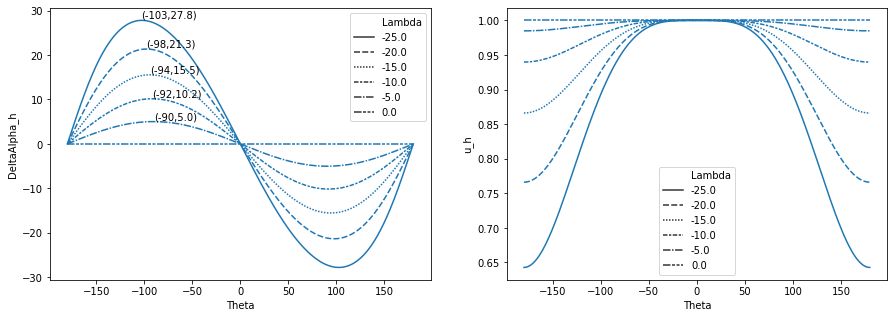

In [12]:
d = df[(pd.Series((np.isin(df['Lambda'],[-25,-20,-15,-10,-5,0])))) & (df['Alpha']==0) & (df['Beta']==0)]
fig, axes = plt.subplots(1,2,figsize=(15,5))
ax = sns.lineplot(data = d,x='Theta',y='DeltaAlpha_h',style='Lambda',ax=axes[0])
ax = sns.lineplot(data = d,x='Theta',y='u_h',style='Lambda',ax=axes[1])
        
# annotate maximums
AnnotateMaxs(data=d,group='Lambda',x='Theta',y='DeltaAlpha_h',ax=axes[0])

The maximum alpha_h does not occur at 90 degrees, $\Lambda$ has the effect of delaying it, and also increasing its value.

However, this does not take in to account that the effective velocity has also reduced due to the increased sweep angle. The standard equation for the change in lift of the hinge is:

$\Delta L = \frac{1}{2}\rho u_h^2SC_L\Delta\alpha_h$ 

and assuming everything remains constant except for $\Delta\alpha_h$ & $V$, we can say:

$\Delta L \propto u_h^2\Delta\alpha_h$

Plotting this change for the same cases as above...

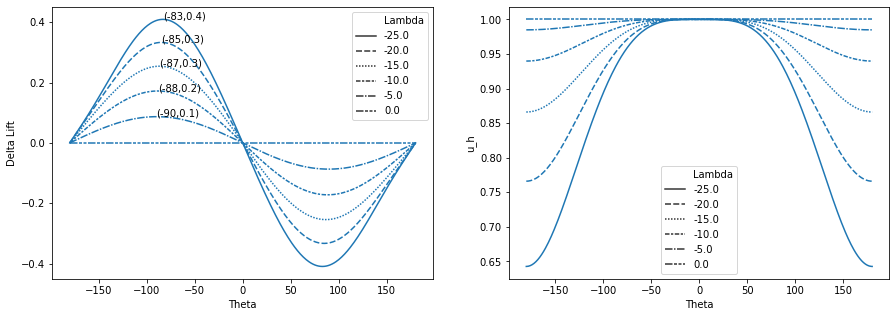

In [13]:
AoA_e = np.deg2rad(df['DeltaAlpha_h'])
df['Delta Lift'] = df['u_h']*df['u_h']*AoA_e
# df['Delta Lift'] = df['u_h']*df['u_h']*AoA_e*np.cos(AoA_e)

d = df[(pd.Series((np.isin(df['Lambda'],[-25,-20,-15,-10,-5,0])))) & (df['Alpha']==0) & (df['Beta']==0)]

fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.lineplot(data = d,x='Theta',y='Delta Lift',style='Lambda',ax=axes[0])
sns.lineplot(data = d,x='Theta',y='u_h',style='Lambda',ax=axes[1])


AnnotateMaxs(data=d,group='Lambda',x='Theta',y='Delta Lift',ax=axes[0],yOffset=0)

The maximum moves closer to 0 degrees (rememeber the theta data was only claculated on 5 degrees increments atm)

## Take the Case of the WTT model ($\Lambda = -10^o$)

How does varying the AoA vary the plot above?

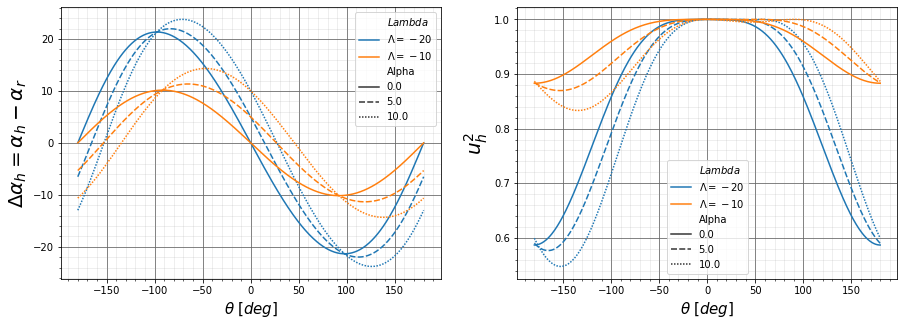

In [16]:
d = df[(pd.Series((np.isin(df['Alpha'],[0,5,10])))) & (pd.Series((np.isin(df['Lambda'],[-10,-20])))) & (df['Beta']==0)]
d =d .copy()
d['u_h^2']= d['u_h']**2
d['$Lambda$'] = np.array(list(map(lambda x: f'$\\Lambda = {x:.0f}$', d['Lambda'])))

fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.lineplot(data = d,x='Theta',y='Alpha_h',style='Alpha',hue='$Lambda$',ax=axes[0])
sns.lineplot(data = d,x='Theta',y='u_h^2',style='Alpha',hue='$Lambda$',ax=axes[1])

for i in [0,1]:
    axes[i].set_xlabel(r'$\theta\;[deg]$',fontsize=15)
    # Show the major grid lines with dark grey lines
    axes[i].grid(b=True, which='major', color='#666666', linestyle='-')

    # Show the minor grid lines with very faint and almost transparent grey lines
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    
axes[0].set_ylabel(r'$\Delta\alpha_h=\alpha_h-\alpha_r$',fontsize=20,rotation=90)
axes[1].set_ylabel(r'$u_h^2$',fontsize=20,rotation=90)

#AnnotateMaxs(data=d,group='Alpha',x='Theta',y='DeltaAlpha_h',ax=axes[0],xOffset = 25,yOffset =0)

plt.savefig(imageFolder +  r'WTTvariations.png',transparent=True,bbox_inches='tight')


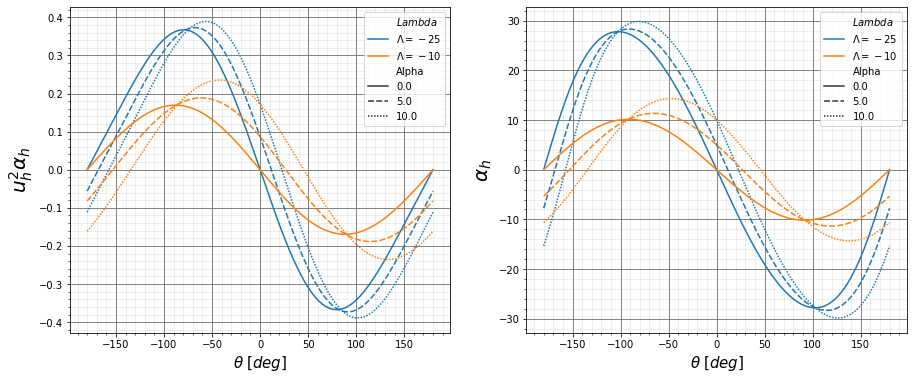

In [148]:
d = df[(pd.Series((np.isin(df['Alpha'],[0,5,10])))) & (pd.Series((np.isin(df['Lambda'],[-10,-25])))) & (df['Beta']==0)]
d = d.copy()
d['$Lambda$'] = np.array(list(map(lambda x: f'$\\Lambda = {x:.0f}$', d['Lambda'])))
## plot the above as a change in lift
aoa_h = np.deg2rad(d['Alpha_h'])
d['Lift']= d['u_h']**2*aoa_h*np.cos(aoa_h) #-np.deg2rad(d['Alpha'])
fig, axes = plt.subplots(1,2,figsize=(15,6))
sns.lineplot(data = d,x='Theta',y='Lift',style='Alpha',hue='$Lambda$',ax=axes[0])
sns.lineplot(data = d,x='Theta',y='Alpha_h',style='Alpha',hue='$Lambda$',ax=axes[1])
for i in [0,1]:
    axes[i].grid(b=True, which='major', color='#666666', linestyle='-')
    axes[i].set_xlabel(r'$\theta\;[deg]$',fontsize=15)
    axes[i].set_ylabel(r'$u_h^2 \alpha_h $',fontsize=20,rotation=90)
    #Show the minor grid lines with very faint and almost transparent grey lines
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)



axes[1].set_ylabel(r'$\alpha_h $',fontsize=20,rotation=90)
plt.savefig(imageFolder +  r'AoALambda_x_Theta_y_uh2alpha.png',transparent=True,bbox_inches='tight')

## Converting to Moments

Lift is perpendicular to the velocity vector not the FWT, hence to accurately predict the moment at the hinge due to aero force we need to consider both the lift and drag forces. If we call the vector perpendicular to the FWT $P$ then:

$P =L\cos\alpha_h + D \sin\alpha_h $ 

$P = \frac{1}{2}\rho u_h^2S \left(C_L(\alpha_h)\cos{\alpha_h}+C_D(\alpha_h)\sin{\alpha_h} \right) $

$P \propto u_h^2 \left(C_L(\alpha_h)\cos{\alpha_h}+C_D(\alpha_h)\sin{\alpha_h} \right) $


we will define C_L as a saturating curve (slope 2 pi between 12 -> -12 and 0 everywhere else)

we will define C_D as whichever one is less of the following two functions

$C_d = \frac{2}{pi}\alpha_h$

$C_d = 6.062\alpha_h^4+0.01$

this follows the C_D slope of a naca0015 airfoil closely up to 20 degrees (goes through 0.1 C_d @ 20 degrees) then transistions to a line which goes upto 1 at 90 degrees (stalled region)

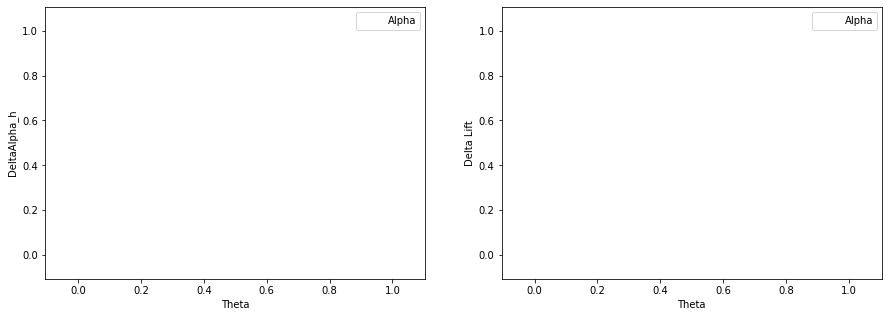

In [16]:
d = df[(pd.Series((np.isin(df['Alpha'],[0,5,10])))) & (df['Lambda']==-10) & (df['Beta']==-10)]

fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.lineplot(data = d,x='Theta',y='DeltaAlpha_h',style='Alpha',ax=axes[0])
sns.lineplot(data = d,x='Theta',y='Delta Lift',style='Alpha',ax=axes[1])

AnnotateMaxs(data=d,group='Alpha',x='Theta',y='DeltaAlpha_h',ax=axes[0])
AnnotateMaxs(data=d,group='Alpha',x='Theta',y='Delta Lift',ax=axes[1])

At $AoA=10$ your maximum lift is achieved at ~-45 degrees and is a less than a 5 degrees variation on your starting angle.

at the start of each run the hinge hung well below 45 degree (closer to 60), wind ramp up, how would that play out for the AoA 10 case?

at the start just hanging, then as soon as it has enough lift to overcome its weight it will jump to the same C_l value on the other side of the hump?

In the WTT the maximum hinge angles achieved were $20 \to -30$ degrees, at 10 degrees AoA  how different are the predictions compared to that from the following equation?

$\Delta\alpha_h(\Lambda,\theta) = -\arctan(\tan{\theta} \sin{\Lambda}$)

[(-30, 30), (-30, 30)]

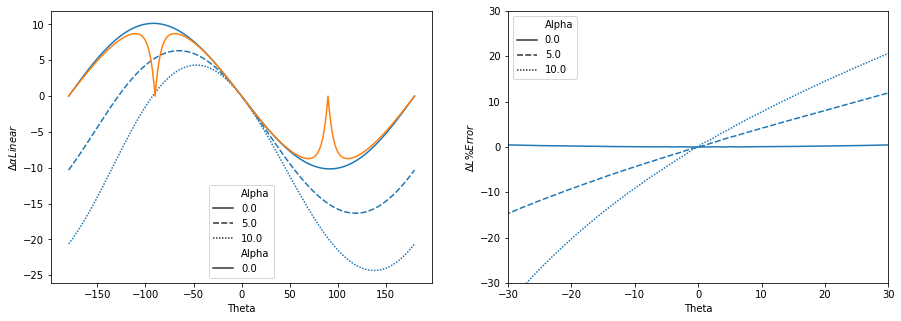

In [27]:
# add linear terms to the main pandas array

dAlphaLin = r'$\Delta\alpha Linear$'
dLiftLin = '$\Delta L Linear$'
dAlphaErrorS = '$\Delta\\alpha Error [Deg]$'
dLiftError = '$\Delta L \% Error$'

df[dAlphaLin] =np.rad2deg(np.arctan(np.tan(np.deg2rad(df['Theta']))*np.sin(np.deg2rad(df['Lambda'])))*np.cos(np.deg2rad(df['Theta'])))
df[dLiftLin] = np.deg2rad(df[dAlphaLin])
df[dAlphaErrorS] = df['DeltaAlpha_h']-df[dAlphaLin]
df[dLiftError] = (np.round(df['Delta Lift'],5)-df[dLiftLin])/np.round(df['Delta Lift'],5)*100

# get data to plot
d = df[(pd.Series((np.isin(df['Alpha'],[0,2.5,5,7.5,10])))) & (df['Lambda']==-10) & (df['Beta']==0)]

fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.lineplot(data = d,x='Theta',y='DeltaAlpha_h',style='Alpha',ax=axes[0])
sns.lineplot(data = d,x='Theta',y= dLiftError ,style='Alpha',ax=axes[1])

# plot the linear data ontop
dLin = d[d['Alpha']==0]
sns.lineplot(data = dLin,x='Theta',y=dAlphaLin, style='Alpha',ax=axes[0])
#sns.lineplot(data = dLin,x='Theta',y=dLiftError, style='Alpha',ax=axes[1])
axes[1].set(xlim=(-30,30),ylim=(-30,30))
#axes[0].set(xlim=(-40,40),ylim=(-2,2))

On the left is the variation in delt alpah for 3 AoA plus the linear model (orange). On the right is % delta lift error between the two models (non-linear minus linear)

The difference on the right at higher angles are clear. At lower angle the two line up a lot better. When considering the percentage lift error, at 0 degrees AoA the differnce is minimal upto +/-10 degrees theta, this error grows significantly as the AoA increases.

Does this need to be considered for trim cases?

At zero degrees AoA the error is small, however even for a small AoA (2.5) you get 2 degrees of error over +/-10 theta!


these effects actually make quite a large difference even within the region we tested / at small angles during the WTT

can I fit the steady case data better with this new model???

### Small angle approximations

In theory the assumption made to lead to the equation $\Delta\alpha_h(\Lambda,\theta) = -\arctan(\tan{\theta} \sin{\Lambda}$) was that $\alpha$ is small, and then $\alpha = \beta = 0$. If we take this approximation with the above equation what do we see?

In [37]:
st = sym.sin(alpha)
ct = sym.cos(alpha)
Vh_lin = Vh.subs({beta:0,st:alpha,ct:1})
sym.trigsimp(sym.atan(Vh_lin[2]/Vh_lin[0])).subs(alpha,0)
sym.trigsimp(sym.atan(Vh_lin[2]/Vh_lin[0]))

atan((alpha*cos(theta) + sin(Lambda)*sin(theta))/(-alpha*sin(Lambda)*sin(theta) + sin(Lambda)**2*cos(theta) - sin(Lambda)**2 + 1))

Thats different.... what happpens if I plot that relationship as above??

[(-10, 10), (-10, 10)]

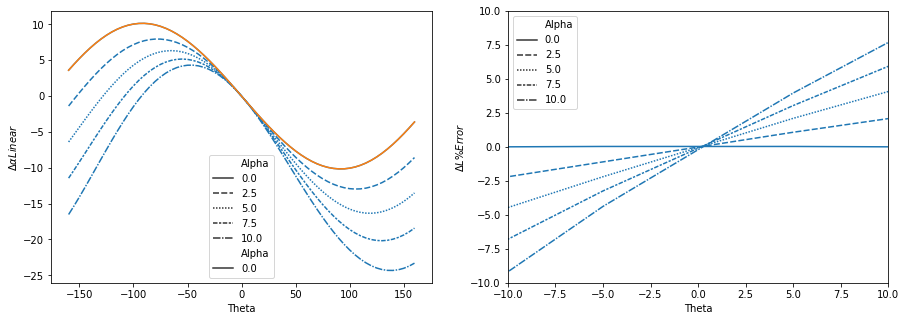

In [38]:
# add linear terms to the main pandas array
sL = np.sin(np.deg2rad(df['Lambda']))
t = np.deg2rad(df['Theta'])
df[dAlphaLin] =np.rad2deg(np.arctan(sL*np.sin(t)/(sL**2*np.cos(t)-sL**2+1)))
df[dLiftLin] = np.deg2rad(df[dAlphaLin])
df[dAlphaErrorS] = df['DeltaAlpha_h']-df[dAlphaLin]
df[dLiftError] = (np.round(df['Delta Lift'],5)-df[dLiftLin])/np.round(df['Delta Lift'],5)*100

# get data to plot
d = df[(pd.Series((np.isin(df['Alpha'],[0,2.5,5,7.5,10])))) & (df['Lambda']==-10) & (df['Beta']==0)]

fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.lineplot(data = d,x='Theta',y='DeltaAlpha_h',style='Alpha',ax=axes[0])
sns.lineplot(data = d,x='Theta',y= dLiftError ,style='Alpha',ax=axes[1])

# plot the linear data ontop
dLin = d[d['Alpha']==0]
sns.lineplot(data = dLin,x='Theta',y=dAlphaLin, style='Alpha',ax=axes[0])
#sns.lineplot(data = dLin,x='Theta',y=dLiftError, style='Alpha',ax=axes[1])
axes[1].set(xlim=(-10,10),ylim=(-10,10))

So for 0 AoA that equation is much better over the region +/-90 degrees $\theta$

I feel something may have gone wrong in the initial derivation of the first equation...

## Including Drag in the Model

Lift is perpendicular to the velocity vector not the FWT, hence to accurately predict the moment at the hinge due to aero force we need to consider both the lift and drag forces. If we call the vector perpendicular to the FWT $P$ then:

$P =L\cos\alpha_h + D \sin\alpha_h $ 

$P = \frac{1}{2}\rho u_h^2S \left(C_L(\alpha_h)\cos{\alpha_h}+C_D(\alpha_h)\sin{\alpha_h} \right) $

$P \propto u_h^2 \left(C_L(\alpha_h)\cos{\alpha_h}+C_D(\alpha_h)\sin{\alpha_h} \right) $


we will define C_L as a saturating curve (slope 2 pi between 12 -> -12 and 0 everywhere else)

we will define C_D as whichever one is less of the following two functions

$C_d = \frac{2}{pi}\alpha_h$

$C_d = 6.062\alpha_h^4+0.01$

this follows the C_D slope of a naca0015 airfoil closely up to 20 degrees (goes through 0.1 C_d @ 20 degrees) then transistions to a line which goes upto 1 at 90 degrees (stalled region)

In [16]:
def CL(alpha,stallAngle=14):
    clipAlpha = np.deg2rad(stallAngle)
    if not isinstance(alpha, (list, tuple, np.ndarray, pd.Series)):
        alpha = alpha if alpha < clipAlpha else clipAlpha*1
    else:
        alpha = np.clip(alpha,-clipAlpha,clipAlpha)
        alpha[np.abs(alpha) == clipAlpha] = alpha[np.abs(alpha) == clipAlpha]*0.9
    cl = 2 * np.pi * alpha
    return cl

def CD(alpha):
    cd1 = 2*alpha/np.pi
    cd2 = 6.062*alpha**4+0.01
    return np.minimum(cd1,cd2)

def P(v,alpha,stallAngle=14):
    return v**2*(np.cos(alpha)*CL(alpha,stallAngle)+np.sin(alpha)*CD(alpha))

Create the new column and plot the above plots for P

False


array([0.54831136, 0.98696044, 0.98696044])

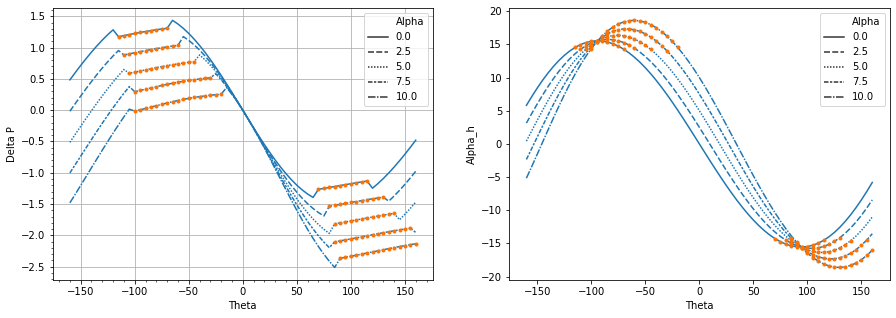

In [17]:
# add linear terms to the main pandas array
ah = np.deg2rad(df['Alpha_h'])
print(not isinstance(np.deg2rad(df['Alpha']),(np.ndarray,pd.Series)))
stallAng = 14

df['Delta P'] = P(df['u_h'],np.deg2rad(df['Alpha_h']),stallAng)-P(1,np.deg2rad(df['Alpha']),stallAng)
df['Stall Mode'] = df['Alpha_h'].apply(lambda x:'Stalled' if np.abs(x) > stallAng else 'Attached')

# get data to plot
d = df[(pd.Series((np.isin(df['Alpha'],[0,2.5,5,7.5,10])))) & (df['Lambda']==-15) & (df['Beta']==0)]

fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.lineplot(data = d,x='Theta',y='Delta P',style='Alpha',ax=axes[0])
sns.lineplot(data = d,x='Theta',y= 'Alpha_h' ,style='Alpha',ax=axes[1])



dataSet = d[d['Stall Mode']=='Stalled']
for i in dataSet['Alpha'].unique():
    dsAlpha = dataSet[dataSet['Alpha'] == i]
    if ~dsAlpha.empty:
        axes[0].plot(dsAlpha['Theta'],dsAlpha['Delta P'],'o',color='xkcd:orange',markersize = 3)
        axes[1].plot(dsAlpha['Theta'],dsAlpha['Alpha_h'],'o',color='xkcd:orange',markersize = 3)

# plot the linear data ontop
dLin = d[d['Alpha']==0]
#sns.lineplot(data = dLin,x='Theta',y=dAlphaLin, style='Alpha',ax=axes[0])
#sns.lineplot(data = dLin,x='Theta',y=dLiftError, style='Alpha',ax=axes[1])
#axes[1].set(xlim=(-10,10),ylim=(-10,10))
axes[0].minorticks_on()
axes[0].grid(True,which='major')

type(axes[0])
CL(np.deg2rad(np.array([5,10,15])),10)

On the left is a term proportional to the the moment about the hinge due to Aero force, and on the left is the corresponding AoA. orange markers indicate regions where the wingtip is stalled. Some important thingss to point out from this plot:

- For negative Theta a positive force a 'restoring force' (i.e tends to pull theta back to zero), and vis versa for a positive theta. This mean for all points, except at extreme angles the FWT tends back to the zero position)
- In the stalled region (which is currently just a saturation curve) if there was a loss of lift with stall it is concieveable, the wingtip could become unstable at quite a low theta angle.
- with this model, although a very crude approximation, at AoA = 0 the FWT would not unfold itself if the fold angle was greater than 150 degrees

## Added the effect of mass / gravity to the FWT

the moment about the hinge of the FWT is a balance between the aero forces plotted above and the force due acceleration acting on the FWT.

$M = P*d_p - mgd_m$

As with the aero forces, we are only interested in the component of weight perpendicular to the FWT, hence we must transform a acceleration vector in the a/c frame of reference into one in the FWT's. For now we will only consider coordinated manouvres ( acceleration pointing vertically down in the a/c frame):

$\mathbf{a} = \begin{bmatrix}0\\0\\-a\end{bmatrix}$

hence in the FWT reference frame

In [18]:
a = sym.Symbol('a')
Aac = sym.Matrix([0,0,-a])
Ah = H_Ac*Aac
Ah

Matrix([
[ a*sin(Lambda)*sin(theta)],
[-a*sin(theta)*cos(Lambda)],
[            -a*cos(theta)]])

We only care about the z component of this force!

# Developing an Equation for the moment about the Hinge

From the above equation the moment balance around the Hinge is:

$M(\theta) = P(\theta)*d_p - ma\cos{\theta}d_m$

considering the equilbrim case in steady level flight, i.e. $M\rvert_{\theta_e} = 0, a = 1$

$P(\theta_e)*d_p = m\cos{\theta_e}d_m$

$md_m = \frac{P(\theta_e)*d_p}{\cos{\theta_e}}$

Subing this back into the initial equation

$M(\theta) = P(\theta)*d_p - a\cos{\theta}\frac{P(\theta_e)*d_p}{\cos{\theta_e}}$

$M(\theta) \propto P(\theta) - a\cos{\theta}\frac{P(\theta_e)}{\cos{\theta_e}}$


Taking a typical trim case for an a/c, $\alpha_e = 5^o$, we can compare how the above plots vary for different weights of FWT (by varying $\theta_e$ between 0->-4 degrees)



In [34]:
def CL(alpha,stallAngle=14):
    clipAlpha = np.deg2rad(stallAngle)
    if not isinstance(alpha, (list, tuple, np.ndarray, pd.Series)):
        alpha = alpha if alpha < clipAlpha else clipAlpha*1
        alpha = alpha if alpha > -clipAlpha else -clipAlpha*1
    else:
        alpha = np.clip(alpha,-clipAlpha,clipAlpha)
        alpha[np.abs(alpha) == clipAlpha] = alpha[np.abs(alpha) == clipAlpha]*0.9
    cl = 1 * np.pi * alpha
    return cl

def CD(alpha):
    cd1 = 2*alpha/np.pi
    cd2 = 6.062*alpha**4+0.01
    return np.minimum(cd1,cd2)

def P(v,alpha,stallAngle=14):
    return v**2*(np.cos(alpha)*CL(alpha,stallAngle)+np.sin(alpha)*CD(alpha))


stallAng = 14
AoAs = np.array([5])
Thetas = np.linspace(-160,160,119)
Lambdas = np.linspace(-25,0,6)
TrimAngle = np.linspace(20,-5,6)

dat = []

for k in Lambdas:
    lam = np.deg2rad(k)
    for i in AoAs:
        aoa = np.deg2rad(i)
        for w in TrimAngle:
            te = np.deg2rad(w)
            v_e = f(aoa,0,lam,te,1).T[0]     
            alpha_e = np.arctan(v_e[2]/v_e[0])
            u_e = np.sqrt(v_e[2]**2+v_e[0]**2)           
            trimVal = P(u_e,alpha_e,stallAng)/np.cos(te)
            for j in Thetas:
                t = np.deg2rad(j)      
                v_h = f(aoa,0,lam,t,1).T[0]       
                alpha_h = np.arctan(v_h[2]/v_h[0])              
                u_h = np.sqrt(v_h[2]**2+v_h[0]**2)
                dP = P(u_h,alpha_h,stallAng)
                da = -trimVal*np.cos(t)
                dM = dP+da
                
                dat.append([i,j,k,w,v_h[0],v_h[1],v_h[2],np.rad2deg(alpha_h),u_h,dM,dP,da])
df2 = pd.DataFrame(data = dat,columns=['Alpha','Theta','Lambda','Trim Angle','v1','v2','v3','Alpha_h','u_h','Delta M','Delta P','Delta a'])
# print(df.head())
df2['DeltaAlpha_h'] = df2['Alpha_h']-df2['Alpha']
df2['Beta_h'] = np.rad2deg((df2['v2']/df2['v1']).apply(np.arctan))

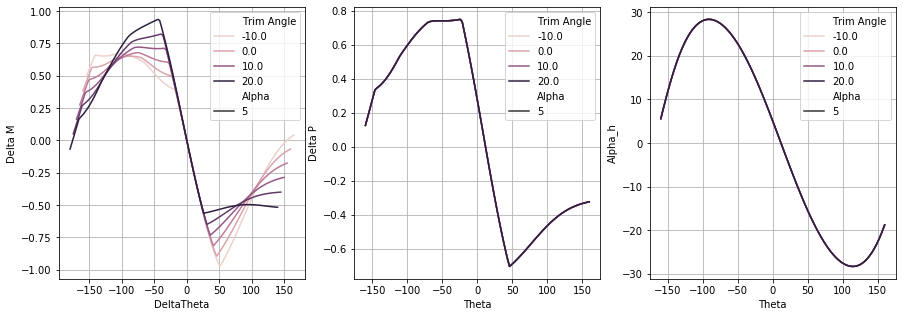

In [35]:
# add linear terms to the main pandas array
ah = np.deg2rad(df2['Alpha_h'])

df2['DeltaTheta'] = df2['Theta']-df2['Trim Angle']
# get data to plot
d = df2[(df2['Lambda']==-25)]

fig, axes = plt.subplots(1,3,figsize=(15,5))
sns.lineplot(data = d,x='DeltaTheta',y='Delta M',style='Alpha',hue='Trim Angle',ax=axes[0])
sns.lineplot(data = d,x='Theta',y= 'Delta P' ,style='Alpha',hue='Trim Angle',ax=axes[1])
sns.lineplot(data = d,x='Theta',y= 'Alpha_h' ,style='Alpha',hue='Trim Angle',ax=axes[2])


#dataSet = d[d['Stall Mode']=='Stalled']
#for i in dataSet['Alpha'].unique():
#    dsAlpha = dataSet[dataSet['Alpha'] == i]
#    if ~dsAlpha.empty:
#        axes[0].plot(dsAlpha['Theta'],dsAlpha['Delta P'],'o',color='xkcd:orange',markersize = 3)
#        axes[1].plot(dsAlpha['Theta'],dsAlpha['Alpha_h'],'o',color='xkcd:orange',markersize = 3)

# plot the linear data ontop
#dLin = d[d['Alpha']==0]
#sns.lineplot(data = dLin,x='Theta',y=dAlphaLin, style='Alpha',ax=axes[0])
#sns.lineplot(data = dLin,x='Theta',y=dLiftError, style='Alpha',ax=axes[1])
#axes[0].set(xlim=(-10,10))
#axes[0].minorticks_on()

for ax in axes:
    ax.grid(True,which='major')

#type(axes[0])
#CL(np.deg2rad(np.array([5,10,15])),10)

Hard to infer much from this, need to trim the a/c at a set effective alpha_h, then for each case find out what theta relates to this angle

## Questions:

can i better fit the WTT trim data using this model over the linear one

Does this need to be considered for trim cases

what happens when you include a $C_L$ curve that accounts for stall?



